<a href="https://colab.research.google.com/github/muhiqbalalamin/DeepLearning/blob/main/CNN_MLP_CIFAR_100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch

CNN and MLP Model Using CIFAR-100 Datasets


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import warnings
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [ ]:
# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.utils.data.dataloader")
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load CIFAR-100 dataset
dataset_train = datasets.CIFAR100(root="./data", train=True, transform=transform, download=True)
dataset_test = datasets.CIFAR100(root="./data", train=False, transform=transform, download=True)

# Create data loaders
train_loader = DataLoader(dataset_train, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(dataset_test, batch_size=64, shuffle=False, num_workers=4)

In [ ]:
# Define CNN Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 100)
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return self.softmax(x)

# Define MLP Model
class MLPModel(nn.Module):
    def __init__(self):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 100)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# Training function
def train_model(model, train_loader, test_loader, num_epochs=25):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_acc, val_acc = [], []
    train_loss, val_loss = [], []

    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        all_preds, all_labels = [], []

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        train_loss.append(total_loss / len(train_loader))
        train_acc.append(accuracy_score(all_labels, all_preds))

        # Validation phase
        model.eval()
        val_correct, val_total, val_loss_epoch = 0, 0, 0
        val_preds, val_labels = [], []

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss_epoch += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

                val_preds.extend(predicted.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_loss.append(val_loss_epoch / len(test_loader))
        val_acc.append(accuracy_score(val_labels, val_preds))

        precision = precision_score(val_labels, val_preds, average='macro')
        recall = recall_score(val_labels, val_preds, average='macro')
        f1 = f1_score(val_labels, val_preds, average='macro')
        auc = roc_auc_score(np.eye(100)[val_labels], np.eye(100)[val_preds], multi_class='ovr')

        print(f"Epoch {epoch+1}/{num_epochs}: Accuracy: {val_acc[-1]:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, AUC: {auc:.4f}")

    # Plot accuracy and loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), train_acc, label='Training Accuracy')
    plt.plot(range(1, num_epochs+1), val_acc, label='Validation Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Training vs Validation Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), train_loss, label='Training Loss')
    plt.plot(range(1, num_epochs+1), val_loss, label='Validation Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training vs Validation Loss")

    plt.show()


Training CNN Model...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25: Accuracy: 0.2851, Precision: 0.3108, Recall: 0.2851, F1-Score: 0.2632, AUC: 0.6389
Epoch 2/25: Accuracy: 0.3545, Precision: 0.3742, Recall: 0.3545, F1-Score: 0.3354, AUC: 0.6740
Epoch 3/25: Accuracy: 0.3891, Precision: 0.4147, Recall: 0.3891, F1-Score: 0.3832, AUC: 0.6915
Epoch 4/25: Accuracy: 0.4110, Precision: 0.4363, Recall: 0.4110, F1-Score: 0.4081, AUC: 0.7025
Epoch 5/25: Accuracy: 0.4138, Precision: 0.4404, Recall: 0.4138, F1-Score: 0.4121, AUC: 0.7039
Epoch 6/25: Accuracy: 0.4027, Precision: 0.4314, Recall: 0.4027, F1-Score: 0.4046, AUC: 0.6983
Epoch 7/25: Accuracy: 0.3988, Precision: 0.4165, Recall: 0.3988, F1-Score: 0.3989, AUC: 0.6964
Epoch 8/25: Accuracy: 0.3933, Precision: 0.4093, Recall: 0.3933, F1-Score: 0.3938, AUC: 0.6936
Epoch 9/25: Accuracy: 0.3912, Precision: 0.4078, Recall: 0.3912, F1-Score: 0.3927, AUC: 0.6925
Epoch 10/25: Accuracy: 0.3911, Precision: 0.4056, Recall: 0.3911, F1-Score: 0.3910, AUC: 0.6925
Epoch 11/25: Accuracy: 0.3853, Precision: 0.3970,

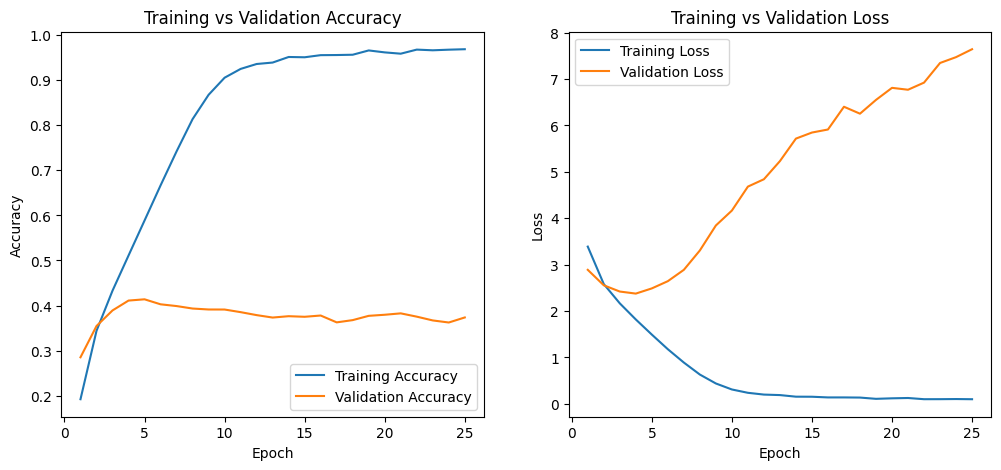

In [ ]:
# Train CNN model
cnn_model = CNNModel()
print("Training CNN Model...")
train_model(cnn_model, train_loader, test_loader)


Training MLP Model...
Epoch 1/25: Accuracy: 0.1662, Precision: 0.1630, Recall: 0.1662, F1-Score: 0.1463, AUC: 0.5789
Epoch 2/25: Accuracy: 0.2063, Precision: 0.1994, Recall: 0.2063, F1-Score: 0.1882, AUC: 0.5991
Epoch 3/25: Accuracy: 0.2164, Precision: 0.2104, Recall: 0.2164, F1-Score: 0.1959, AUC: 0.6042
Epoch 4/25: Accuracy: 0.2221, Precision: 0.2259, Recall: 0.2221, F1-Score: 0.2097, AUC: 0.6071
Epoch 5/25: Accuracy: 0.2252, Precision: 0.2266, Recall: 0.2252, F1-Score: 0.2111, AUC: 0.6087
Epoch 6/25: Accuracy: 0.2370, Precision: 0.2332, Recall: 0.2370, F1-Score: 0.2254, AUC: 0.6146
Epoch 7/25: Accuracy: 0.2411, Precision: 0.2417, Recall: 0.2411, F1-Score: 0.2303, AUC: 0.6167
Epoch 8/25: Accuracy: 0.2424, Precision: 0.2414, Recall: 0.2424, F1-Score: 0.2331, AUC: 0.6174
Epoch 9/25: Accuracy: 0.2425, Precision: 0.2385, Recall: 0.2425, F1-Score: 0.2295, AUC: 0.6174
Epoch 10/25: Accuracy: 0.2337, Precision: 0.2337, Recall: 0.2337, F1-Score: 0.2279, AUC: 0.6130
Epoch 11/25: Accuracy: 0.23

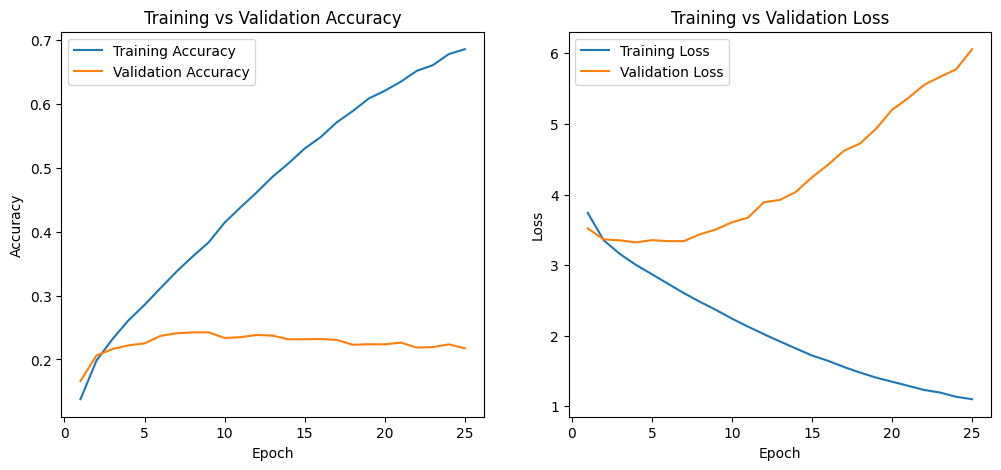

In [ ]:
# Train MLP model
mlp_model = MLPModel()
print("Training MLP Model...")
train_model(mlp_model, train_loader, test_loader)

# TensorFLow
CNN and MLP Model Using CIFAR-100 Datasets

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def preprocess(features):
    image = tf.image.convert_image_dtype(features['image'], tf.float32)
    image = tf.image.random_flip_left_right(image)  # Data Augmentation
    label = tf.one_hot(features['label'], 100)
    return image, label

In [ ]:
# Load CIFAR-100 dataset
dataset_train = tfds.load("cifar100", split="train", as_supervised=False)
dataset_test = tfds.load("cifar100", split="test", as_supervised=False)

dataset_train = dataset_train.map(preprocess).batch(64).prefetch(tf.data.experimental.AUTOTUNE)
dataset_test = dataset_test.map(preprocess).batch(64).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
# Define CNN Model
cnn_model = keras.Sequential([
    layers.Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(32,32,3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(100, activation='softmax')
])

cnn_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

# Define MLP Model
mlp_model = keras.Sequential([
    layers.Flatten(input_shape=(32,32,3)),
    layers.Dense(1024, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(100, activation='softmax')
])

mlp_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Plot accuracy and loss
def plot_metrics(history, title):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title(f"{title} Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"{title} Loss")
    plt.show()

Training CNN Model...
Epoch 1/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.0667 - loss: 5.2192 - val_accuracy: 0.1621 - val_loss: 4.0945 - learning_rate: 5.0000e-04
Epoch 2/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.1697 - loss: 3.9038 - val_accuracy: 0.2711 - val_loss: 3.2689 - learning_rate: 5.0000e-04
Epoch 3/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.2478 - loss: 3.3356 - val_accuracy: 0.3455 - val_loss: 2.8796 - learning_rate: 5.0000e-04
Epoch 4/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.3007 - loss: 3.0353 - val_accuracy: 0.3784 - val_loss: 2.7373 - learning_rate: 5.0000e-04
Epoch 5/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.3420 - loss: 2.8691 - val_accuracy: 0.4079 - val_loss: 2.6267 - learning_rate: 5.0000e-04
Epoch 6/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.3841 - loss: 2.7304 - val_accuracy: 0.3938 - val_loss: 2.8194 - learning_rate: 5.0000e-04
Epoch 7/25
782/782 ━━━━━━━━━━━━━━━━━━

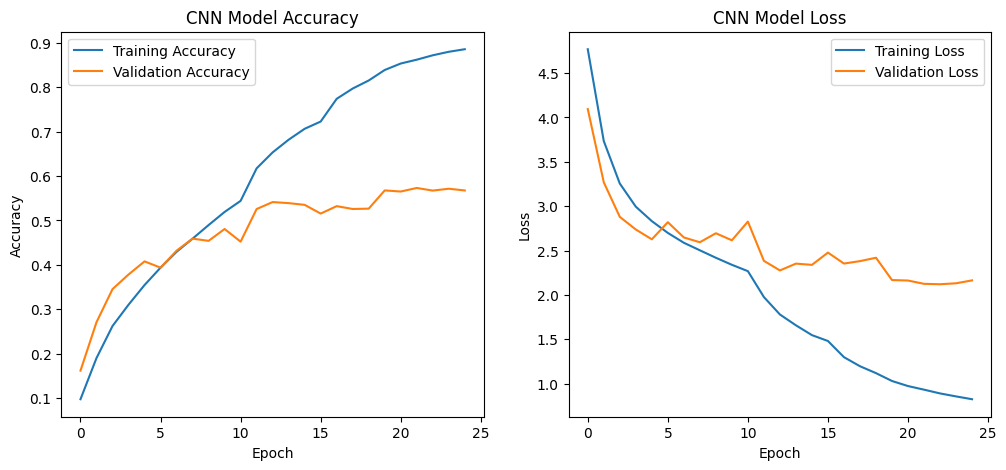

In [ ]:
# Train CNN Model
print("Training CNN Model...")
history_cnn = cnn_model.fit(dataset_train, validation_data=dataset_test, epochs=25, callbacks=[keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5)])
plot_metrics(history_cnn, "CNN Model")

Training MLP Model...
Epoch 1/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.0207 - loss: 5.7861 - val_accuracy: 0.0553 - val_loss: 4.3237 - learning_rate: 5.0000e-04
Epoch 2/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.0442 - loss: 4.3950 - val_accuracy: 0.0836 - val_loss: 4.1163 - learning_rate: 5.0000e-04
Epoch 3/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.0522 - loss: 4.2304 - val_accuracy: 0.0967 - val_loss: 4.0580 - learning_rate: 5.0000e-04
Epoch 4/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.0586 - loss: 4.1601 - val_accuracy: 0.0959 - val_loss: 4.0081 - learning_rate: 5.0000e-04
Epoch 5/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.0653 - loss: 4.1147 - val_accuracy: 0.1083 - val_loss: 3.9854 - learning_rate: 5.0000e-04
Epoch 6/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.0661 - loss: 4.1020 - val_accuracy: 0.1145 - val_loss: 3.9764 - learning_rate: 5.0000e-04
Epoch 7/25
782/782 ━━━━━━━━━━━━━━━━━━━

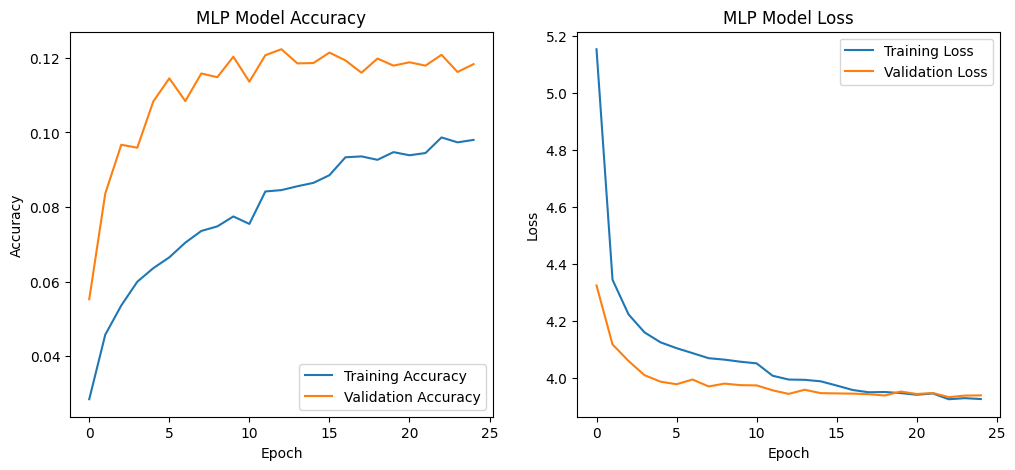

In [ ]:
# Train MLP Model
print("Training MLP Model...")
history_mlp = mlp_model.fit(dataset_train, validation_data=dataset_test, epochs=25, callbacks=[keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5)])
plot_metrics(history_mlp, "MLP Model")